# Preprocessing Yellow taxi Data (.parquet)

A significant amount of this code was adapted from the MAST30034 - Applied Data Science tutorial notebook.

In addition to that, chatGPT was used in debugging the code for any errors that came up as suggested by the tutors for the course.

In [1]:
# Import packages required (aside the ones for the spark session and spark data frame)
import math
import matplotlib.pyplot as plt
import pandas as pd

## Start Spark Session to parse parquet files

In [2]:
# The following code for the spark session has been adapted from the Applied Data Science (MAST30034) Tutorial 1
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, unix_timestamp
from pyspark.sql import functions as F
import os

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Project 1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.driver.memory', '4g')
    .config('spark.executor.memory', '2g')
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/25 16:21:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Read in the yellow taxi parquet files

In [3]:
# Read in the yellow taxi month that has the correct schema
sdf_feb = spark.read.parquet('../data/landing/yellow_2023-02.parquet')
sdf_feb.printSchema()
# ensure everything has consistent casing to make our lives easier
consistent_col_casing = [F.col(col_name).alias(col_name.lower()) for col_name in sdf_feb.columns]
sdf_feb = sdf_feb.select(*consistent_col_casing)

# this will be used in the cell below when reading in all the other files
sdf_schema = sdf_feb.schema
sdf_schema

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)



StructType([StructField('vendorid', IntegerType(), True), StructField('tpep_pickup_datetime', TimestampNTZType(), True), StructField('tpep_dropoff_datetime', TimestampNTZType(), True), StructField('passenger_count', LongType(), True), StructField('trip_distance', DoubleType(), True), StructField('ratecodeid', LongType(), True), StructField('store_and_fwd_flag', StringType(), True), StructField('pulocationid', IntegerType(), True), StructField('dolocationid', IntegerType(), True), StructField('payment_type', LongType(), True), StructField('fare_amount', DoubleType(), True), StructField('extra', DoubleType(), True), StructField('mta_tax', DoubleType(), True), StructField('tip_amount', DoubleType(), True), StructField('tolls_amount', DoubleType(), True), StructField('improvement_surcharge', DoubleType(), True), StructField('total_amount', DoubleType(), True), StructField('congestion_surcharge', DoubleType(), True), StructField('airport_fee', DoubleType(), True)])

In [4]:
# Define the directory path for all the parquet files that are read and the schema is changed
# For consistency purposes
output_dir = '../data/raw/yellow'

# Check if the directory exists, if not, create it
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [5]:
# Read in January 2023 - previously found the schema for this had issues and didn't align
sdf_malformed_jan = spark.read.parquet('../data/landing/yellow_2023-01.parquet')

# select all columns from the existing malformed dataframe and cast it to the required schema
sdf_malformed_jan = sdf_malformed_jan \
    .select([F.col(c).cast(sdf_schema[i].dataType) for i, c in enumerate(sdf_malformed_jan.columns)])

In [6]:
# Svae the data type transformed file
sdf_malformed_jan \
    .coalesce(1) \
    .write \
    .mode('overwrite') \
    .parquet('../data/raw/yellow/yellow_2023-01')

In [7]:
# Similar to January, the October schema was also one that was found to be not in the correct format
sdf_malformed_oct = spark.read.parquet('../data/landing/yellow_2023-10.parquet')

# select all columns from the existing malformed dataframe and cast it to the required schema
sdf_malformed_oct = sdf_malformed_oct \
    .select([F.col(c).cast(sdf_schema[i].dataType) for i, c in enumerate(sdf_malformed_oct.columns)])

In [8]:
# Save the data type transformed file
sdf_malformed_oct \
    .coalesce(1) \
    .write \
    .mode('overwrite') \
    .parquet('../data/raw/yellow/yellow_2023-10')

Read in all the other files which do not necessarily need to be transformed based on the schema.

In [9]:
# Loop through 2023 months (February to October) and add January, November, December, and early 2024
for year_month in ['2023-02', '2023-03', '2023-04', '2023-05', '2023-06', '2023-07', '2023-08', '2023-09', '2023-11', '2023-12',
                   '2024-01', '2024-02', '2024-03', '2024-04']:
    input_path = f'../data/landing/yellow_{year_month}.parquet'
    output_path = f'../data/raw/yellow/yellow_{year_month}.parquet'
    
    # Read, process, and save the data
    sdf = spark.read \
        .schema(sdf_schema) \
        .parquet(input_path) \
        .coalesce(1) \
        .write \
        .mode('overwrite') \
        .parquet(output_path)


24/08/25 16:22:11 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


### Create Spark Dataframe for all the yellow taxi data (with the correct schema)

In [10]:
sdf = spark.read.schema(sdf_schema).parquet('../data/raw/yellow/*')

sdf.show(1, vertical=True, truncate=100)

-RECORD 0------------------------------------
 vendorid              | 1                   
 tpep_pickup_datetime  | 2024-03-01 00:18:51 
 tpep_dropoff_datetime | 2024-03-01 00:23:45 
 passenger_count       | 0                   
 trip_distance         | 1.3                 
 ratecodeid            | 1                   
 store_and_fwd_flag    | N                   
 pulocationid          | 142                 
 dolocationid          | 239                 
 payment_type          | 1                   
 fare_amount           | 8.6                 
 extra                 | 3.5                 
 mta_tax               | 0.5                 
 tip_amount            | 2.7                 
 tolls_amount          | 0.0                 
 improvement_surcharge | 1.0                 
 total_amount          | 16.3                
 congestion_surcharge  | 2.5                 
 airport_fee           | 0.0                 
only showing top 1 row



In [11]:
sdf.limit(5)

vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
1,2024-03-01 00:18:51,2024-03-01 00:23:45,0,1.3,1,N,142,239,1,8.6,3.5,0.5,2.7,0.0,1.0,16.3,2.5,0.0
1,2024-03-01 00:26:00,2024-03-01 00:29:06,0,1.1,1,N,238,24,1,7.2,3.5,0.5,3.0,0.0,1.0,15.2,2.5,0.0
2,2024-03-01 00:09:22,2024-03-01 00:15:24,1,0.86,1,N,263,75,2,7.9,1.0,0.5,0.0,0.0,1.0,10.4,0.0,0.0
2,2024-03-01 00:33:45,2024-03-01 00:39:34,1,0.82,1,N,164,162,1,7.9,1.0,0.5,1.29,0.0,1.0,14.19,2.5,0.0
1,2024-03-01 00:05:43,2024-03-01 00:26:22,0,4.9,1,N,263,7,2,25.4,3.5,0.5,0.0,0.0,1.0,30.4,2.5,0.0


In [12]:
sdf.count()

83100468

## View statistics for spark dataframe

In [13]:
# Show summary statistics for all numeric columns
sdf.describe().show()

24/08/25 16:22:59 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+-------------------+-----------------+-----------------+---------------------+-----------------+--------------------+-------------------+
|summary|          vendorid|   passenger_count|    trip_distance|        ratecodeid|store_and_fwd_flag|      pulocationid|     dolocationid|      payment_type|       fare_amount|            extra|            mta_tax|       tip_amount|     tolls_amount|improvement_surcharge|     total_amount|congestion_surcharge|        airport_fee|
+-------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+-------------------+-----------------+-----------------+---------------------+-----------------+--------------------+-------------------

In [14]:
# Add a new column for the trip duration in minutes
sdf = sdf.withColumn(
    "trip_duration_minutes",
    (unix_timestamp(col("tpep_dropoff_datetime")) - unix_timestamp(col("tpep_pickup_datetime"))) / 60
)

# Show the DataFrame with the new column
sdf.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+---------------------+
|vendorid|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|ratecodeid|store_and_fwd_flag|pulocationid|dolocationid|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|trip_duration_minutes|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+---------------------+
|       1| 2024-03-01 00:18:51|  2024-03-01 00:23:45|              0|          1.3|         1|                 N|        

In [15]:
# Show summary statistics for all numeric columns
sdf.describe().show()

+-------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+-------------------+-----------------+-----------------+---------------------+-----------------+--------------------+-------------------+---------------------+
|summary|          vendorid|   passenger_count|    trip_distance|        ratecodeid|store_and_fwd_flag|      pulocationid|     dolocationid|      payment_type|       fare_amount|            extra|            mta_tax|       tip_amount|     tolls_amount|improvement_surcharge|     total_amount|congestion_surcharge|        airport_fee|trip_duration_minutes|
+-------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+-------------------+-----------------+-----------------+---------------------+--------------

## Keeping valid taxi rides
This is based on the data dictionary for the yellow taxi trips and other information found about taxi trips here: https://home.nyc.gov/site/tlc/passengers/taxi-fare.page

In [16]:
sdf = sdf.filter((col("vendorid").isin([1, 2])) &                      # trips can only have the vendor id be 1 or 2
                ((col("ratecodeid") >= 1) & (col("ratecodeid") <= 6)) &                      # rate code id can only be between 1 and 6
                ((col("payment_type") >= 1) & (col("payment_type") <= 6)) &                 # valid payment type is an integer between 1 and 6
                ((col("passenger_count") > 0) & (col("passenger_count") <= 6)) &            # decided to keep a reasonable number of passengers
                (col("fare_amount") > 3) &                              # valid fare amount (greater than $3)
                (col("trip_distance") > 0.4) &                          # valid trip distance -> people could have walked otherwise
                (col("mta_tax") >= 0) &                                 # valid tax amount (non negative)
                (col("tip_amount") >= 0) &                              # valid tip amount (non negative)
                (col("tolls_amount") >= 0) &                            # valid tolls amount (non negative)
                (col("total_amount") > 3) &                             # valid total amount (greater than $3)
                (col("improvement_surcharge") >= 0) &                   # valid improvement surcharge (non negative)
                (col("extra") >= 0) &                                   # valid extra (non negative)
                (col("congestion_surcharge") >= 0) &                    # valid congestion charge (non negative)
                (col("tpep_pickup_datetime").between("2023-01-01 00:00:00", "2024-04-30 23:59:59")) &           # in the date range i want
                (col("tpep_dropoff_datetime").between("2023-01-01 00:00:00", "2024-04-30 23:59:59")) &          # in the date range i want
                ((col("pulocationid") >= 1) & (col("pulocationid") <= 263)) &               # pickup location is a valid taxi zone
                ((col("dolocationid") >= 1) & (col("dolocationid") <= 263)) &               # dropoff location is a valid taxi zone
                (col("trip_duration_minutes") > 0)
               )

In [17]:
sdf.count()

73146425

In [18]:
# Show summary statistics for all numeric columns
sdf.describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-------------------+------------------+------------------+-------------------+------------------+------------------+---------------------+------------------+--------------------+-------------------+---------------------+
|summary|          vendorid|   passenger_count|     trip_distance|        ratecodeid|store_and_fwd_flag|      pulocationid|     dolocationid|       payment_type|       fare_amount|             extra|            mta_tax|        tip_amount|      tolls_amount|improvement_surcharge|      total_amount|congestion_surcharge|        airport_fee|trip_duration_minutes|
+-------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-------------------+------------------+------------------+-------------------+------------------+------------------+-------------------

## Removing outliers within the data
This is done using the $\sqrt(log(N)) - 0.5$ method explained in Lecture 2 - Data Cleaning of MAST30034 Applied Data Science

In [19]:
# Calculate IQR for tip_amount and fare_amount, trip_distance, and trip_duration_minutes
def calculate_bounds(df, column):
    count = df.count()
    quantiles = df.approxQuantile(column, [0.25, 0.75], 0.05)
    q1 = quantiles[0]
    q3 = quantiles[1]
    iqr = q3 - q1
    factor = (math.sqrt(math.log(count)) - 0.5)
    lower_bound = q1 - factor * iqr
    upper_bound = q3 + factor * iqr
    return lower_bound, upper_bound

# Calculate the bounds for the outliers
tip_amount_bounds = calculate_bounds(sdf, "tip_amount")
fare_amount_bounds = calculate_bounds(sdf, "fare_amount")
trip_distance_bounds = calculate_bounds(sdf, "trip_distance")
trip_duration_bounds = calculate_bounds(sdf, "trip_duration_minutes")

# Filter out outliers in tip_amount, fare_amount, and trip_distance
sdf = sdf.filter(
    (col("tip_amount") >= tip_amount_bounds[0]) & (col("tip_amount") <= tip_amount_bounds[1])
)
sdf = sdf.filter(
    (col("fare_amount") >= fare_amount_bounds[0]) & (col("fare_amount") <= fare_amount_bounds[1])
)
sdf = sdf.filter(
    (col("trip_distance") >= trip_distance_bounds[0]) & (col("trip_distance") <= trip_distance_bounds[1])
)
sdf = sdf.filter(
    (col("trip_duration_minutes") >= trip_duration_bounds[0]) & (col("trip_duration_minutes") <= trip_duration_bounds[1])
)

In [20]:
# Show summary statistics for all numeric columns
sdf.describe().show()

+-------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+------------------+------------------+---------------------+------------------+--------------------+-------------------+---------------------+
|summary|          vendorid|   passenger_count|     trip_distance|         ratecodeid|store_and_fwd_flag|      pulocationid|      dolocationid|      payment_type|       fare_amount|             extra|             mta_tax|        tip_amount|      tolls_amount|improvement_surcharge|      total_amount|congestion_surcharge|        airport_fee|trip_duration_minutes|
+-------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+------------------+------------------+-------------

## Removed any trips to and from the airport 
It is assumed that they will not be significant in knowing trips to and from locations related to events

In [21]:
# List of airport zones in NYC TLC data (e.g., JFK, LaGuardia, Newark)
airport_zones = [1, 132, 138] 

# Filter out trips from airports
sdf = sdf.filter(~(col('pulocationid').isin(airport_zones)))


In [22]:
sdf.count()

64840171

In [23]:
# Show summary statistics for all numeric columns
sdf.describe().show()

+-------+------------------+------------------+------------------+-------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+--------------------+------------------+-------------------+---------------------+------------------+--------------------+--------------------+---------------------+
|summary|          vendorid|   passenger_count|     trip_distance|         ratecodeid|store_and_fwd_flag|     pulocationid|     dolocationid|      payment_type|       fare_amount|             extra|             mta_tax|        tip_amount|       tolls_amount|improvement_surcharge|      total_amount|congestion_surcharge|         airport_fee|trip_duration_minutes|
+-------+------------------+------------------+------------------+-------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+--------------------+------------------+-------------------+--------------

In [24]:
# List of airport zones in NYC TLC data (e.g., JFK, LaGuardia, Newark)
airport_zones = [1, 132, 138]

# Filter out trips to airports
sdf = sdf.filter(~(col('dolocationid').isin(airport_zones)))

sdf.count()

64344743

## Only keep columns that will be needed in visualization and modeling

In [25]:
# Selecting the columns to keep: pickup and dropoff times and locations will be key
selected_columns = ['tpep_pickup_datetime', 'tpep_dropoff_datetime',  
                    'pulocationid', 'dolocationid']

sdf = sdf.select(*selected_columns)

# Show the first few rows of the filtered DataFrame to verify
sdf.limit(5)

tpep_pickup_datetime,tpep_dropoff_datetime,pulocationid,dolocationid
2024-03-01 00:09:22,2024-03-01 00:15:24,263,75
2024-03-01 00:33:45,2024-03-01 00:39:34,164,162
2024-03-01 00:50:42,2024-03-01 01:10:40,238,159
2024-03-01 00:08:23,2024-03-01 00:17:53,161,141
2024-03-01 00:24:58,2024-03-01 00:30:31,236,237


In [26]:
sdf.write.mode("overwrite").parquet('../data/raw/yellow_taxi.parquet')

## Calculate number of trips per month

In [27]:
# Extract year and month as separate columns
sdf = sdf.withColumn('year', F.year('tpep_pickup_datetime'))
sdf = sdf.withColumn('month', F.month('tpep_pickup_datetime'))

# Create a combined 'year_month' column
sdf = sdf.withColumn('year_month', F.concat_ws('-', sdf['year'], sdf['month']))

# Perform the aggregation
monthly_aggregates = sdf.groupBy('year_month').agg(
    F.count('*').alias('trip_count')  # Counting the number of trips
)

# Show the result
monthly_aggregates.show()

+----------+----------+
|year_month|trip_count|
+----------+----------+
|    2024-4|   2509080|
|    2024-3|   2560013|
|    2024-2|   2329604|
|   2023-11|   5197235|
|    2023-9|   4312405|
|   2023-10|   2714313|
|    2023-4|   5176194|
|    2023-5|   5495568|
|    2023-8|   4347962|
|    2023-6|   5154936|
|    2023-7|   4508008|
|    2023-2|   4677869|
|    2023-3|   5391582|
|   2023-12|   5203848|
|    2024-1|   2315653|
|    2023-1|   2450473|
+----------+----------+



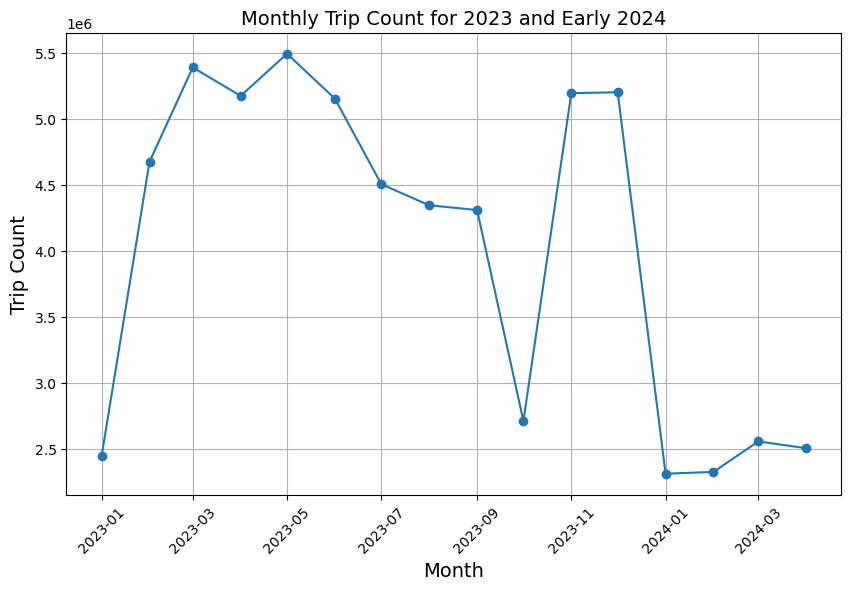

In [28]:
# Convert the PySpark DataFrame to a Pandas DataFrame
monthly_aggregates_pd = monthly_aggregates.toPandas()

# Ensure the 'year_month' column is sorted correctly
monthly_aggregates_pd['year_month'] = pd.to_datetime(monthly_aggregates_pd['year_month'], format='%Y-%m')
monthly_aggregates_pd = monthly_aggregates_pd.sort_values('year_month')

# Plot the monthly trip counts
plt.figure(figsize=(10, 6))
plt.plot(monthly_aggregates_pd['year_month'], monthly_aggregates_pd['trip_count'], marker='o')
plt.title('Monthly Trip Count for 2023 and Early 2024', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Trip Count', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True)
plt.savefig("../plots/monthly_trips.png")
plt.show()


### Calculate hourly pickups by location

In [29]:
# Add hour and date columns for aggregation
sdf = sdf.withColumn('pickup_hour', F.hour('tpep_pickup_datetime'))
sdf = sdf.withColumn('pickup_date', F.to_date('tpep_pickup_datetime'))

# Aggregate: Hourly trip count by pickup location
hourly_trip_puid_count = sdf.groupBy('pickup_date', 'pickup_hour', 'pulocationid').agg(
    F.count('*').alias('trip_count')
)

# Show the result
hourly_trip_puid_count.show()

+-----------+-----------+------------+----------+
|pickup_date|pickup_hour|pulocationid|trip_count|
+-----------+-----------+------------+----------+
| 2024-03-01|          0|         144|        69|
| 2024-03-01|          1|          52|         1|
| 2024-03-01|          2|          45|         1|
| 2024-03-01|          8|         229|        83|
| 2024-03-01|         19|         239|       200|
| 2024-03-02|          0|         237|        65|
| 2024-03-02|          4|          90|        27|
| 2024-03-02|          8|         262|        64|
| 2024-03-02|         10|         249|        76|
| 2024-03-02|         11|         143|        78|
| 2024-03-02|         12|         246|        89|
| 2024-03-02|         18|          45|         3|
| 2024-03-02|         19|         113|        87|
| 2024-03-02|         23|         164|       129|
| 2024-03-03|         15|         140|        65|
| 2024-03-03|         17|         238|       105|
| 2024-03-03|         19|         202|         1|


### Calculate hourly dropoffs by location

In [30]:
# Add hour and date columns for aggregation
sdf = sdf.withColumn('dropoff_hour', F.hour('tpep_dropoff_datetime'))
sdf = sdf.withColumn('dropoff_date', F.to_date('tpep_dropoff_datetime'))

# Aggregate: Hourly trip count by dropoff location
hourly_trip_doid_count = sdf.groupBy('dropoff_date', 'dropoff_hour', 'dolocationid').agg(
    F.count('*').alias('trip_count')
)

# Show the result
hourly_trip_doid_count.show()

+------------+------------+------------+----------+
|dropoff_date|dropoff_hour|dolocationid|trip_count|
+------------+------------+------------+----------+
|  2024-03-01|           0|         144|        55|
|  2024-03-01|           1|         129|         3|
|  2024-03-01|           2|          45|         7|
|  2024-03-01|           4|         195|         1|
|  2024-03-01|           8|         229|        64|
|  2024-03-01|          12|         165|         1|
|  2024-03-01|          19|         239|       201|
|  2024-03-02|           0|         237|        83|
|  2024-03-02|           0|          17|         8|
|  2024-03-02|           3|         256|        15|
|  2024-03-02|           6|         143|         5|
|  2024-03-02|           8|         262|        41|
|  2024-03-02|          10|         249|        67|
|  2024-03-02|          11|         143|        69|
|  2024-03-02|          12|         246|       118|
|  2024-03-03|           5|         161|         2|
|  2024-03-0

## Calculate hourly count of pickups and dropoffs by location
Combining the previous 2 aggregates in one

In [31]:
# Aggregate: Hourly trip count by pickup location
hourly_trip_puid_count = sdf.groupBy('pickup_date', 'pickup_hour', 'pulocationid').agg(
    F.count('*').alias('pickup_trip_count')
).withColumnRenamed('pickup_date', 'date') \
 .withColumnRenamed('pickup_hour', 'hour') \
 .withColumnRenamed('pulocationid', 'location_id')

# Aggregate: Hourly trip count by dropoff location
hourly_trip_doid_count = sdf.groupBy('dropoff_date', 'dropoff_hour', 'dolocationid').agg(
    F.count('*').alias('dropoff_trip_count')
).withColumnRenamed('dropoff_date', 'date') \
 .withColumnRenamed('dropoff_hour', 'hour') \
 .withColumnRenamed('dolocationid', 'location_id')

# Perform an outer join on date, hour, and location ID
combined_trip_count = hourly_trip_puid_count.join(
    hourly_trip_doid_count,
    on=['date', 'hour', 'location_id'],
    how='outer'
)

# Fill any null values with 0 (in case a location has only pickups or only dropoffs)
combined_trip_count = combined_trip_count.fillna({'pickup_trip_count': 0, 'dropoff_trip_count': 0})

# Show the final combined result
combined_trip_count.show()

+----------+----+-----------+-----------------+------------------+
|      date|hour|location_id|pickup_trip_count|dropoff_trip_count|
+----------+----+-----------+-----------------+------------------+
|2023-01-01|   0|         43|               87|                26|
|2023-01-01|   0|         45|                8|                11|
|2023-01-01|   0|         75|               14|                59|
|2023-01-01|   0|        106|                0|                 2|
|2023-01-01|   0|        113|               54|                40|
|2023-01-01|   0|        126|                0|                 1|
|2023-01-01|   0|        148|              131|                57|
|2023-01-01|   0|        151|               39|                45|
|2023-01-01|   0|        168|                0|                 4|
|2023-01-01|   0|        228|                0|                 1|
|2023-01-01|   0|        244|                4|                 8|
|2023-01-01|   1|         12|                1|               

In [32]:
# Define the directory path for where all the aggregated data should be saved
# For visualization & modeling
output_dir = '../data/curated/taxi'

# Check if the directory exists, if not, create it
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [33]:
# Export the dataframe as a parquet file
combined_trip_count.write.mode("overwrite").parquet('../data/curated/taxi/hourly_pu_do_counts_location.parquet')

In [34]:
# Export the data frame as a csv for ease in visualization
combined_trip_count_df = combined_trip_count.toPandas()
combined_trip_count_df.to_csv("../data/curated/taxi/hourly_pu_do_counts_location.csv", index=False)

## Calculate number of pickups and dropoffs by location

In [35]:

# Aggregate: Total pickup count by location ID
pickup_count_by_location = sdf.groupBy('pulocationid').agg(
    F.count('*').alias('total_pickup_count')
)

# Aggregate: Total dropoff count by location ID
dropoff_count_by_location = sdf.groupBy('dolocationid').agg(
    F.count('*').alias('total_dropoff_count')
)

# Perform an outer join on location ID (using coalesce to handle different column names)
combined_location_counts = pickup_count_by_location.join(
    dropoff_count_by_location,
    pickup_count_by_location['pulocationid'] == dropoff_count_by_location['dolocationid'],
    how='outer'
)

# Select and rename columns for clarity
combined_location_counts = combined_location_counts.select(
    F.coalesce(F.col('pulocationid'), F.col('dolocationid')).alias('location_id'),
    F.col('total_pickup_count'),
    F.col('total_dropoff_count')
)

# Fill any null values with 0 (in case a location has only pickups or only dropoffs)
combined_location_counts = combined_location_counts.fillna({'total_pickup_count': 0, 'total_dropoff_count': 0})

# Show the final combined result
combined_location_counts.show()

+-----------+------------------+-------------------+
|location_id|total_pickup_count|total_dropoff_count|
+-----------+------------------+-------------------+
|          2|                25|                  6|
|          3|               124|                386|
|          4|             72576|             269210|
|          5|                 0|                  4|
|          6|                83|                 95|
|          7|             24947|             152390|
|          8|               128|                824|
|          9|               104|                534|
|         10|              1352|               1058|
|         11|               161|                317|
|         12|             31718|              42191|
|         13|            408531|             525416|
|         14|               627|               9972|
|         15|                57|                632|
|         16|                75|                777|
|         17|              2200|              

In [36]:
combined_location_counts_df = combined_location_counts.toPandas()
combined_location_counts_df.to_csv("../data/curated/taxi/pu_do_counts_location.csv", index=False)

## Calculate hourly pickups and dropoffs in general

In [37]:
# Aggregate: Total pickup count by date and hour
pickup_count_by_date_hour = sdf.groupBy('pickup_date', 'pickup_hour').agg(
    F.count('*').alias('total_pickup_count')
).withColumnRenamed('pickup_date', 'date') \
 .withColumnRenamed('pickup_hour', 'hour')

# Aggregate: Total drop-off count by date and hour 
dropoff_count_by_date_hour = sdf.groupBy('dropoff_date', 'dropoff_hour').agg(
    F.count('*').alias('total_dropoff_count')
).withColumnRenamed('dropoff_date', 'date') \
 .withColumnRenamed('dropoff_hour', 'hour')

# Perform an outer join on the renamed date and hour columns
combined_date_hour_counts = pickup_count_by_date_hour.join(
    dropoff_count_by_date_hour,
    on=['date', 'hour'],
    how='outer'
)

# Fill any null values with 0 (in case there are hours with only pickups or only drop-offs)
combined_date_hour_counts = combined_date_hour_counts.fillna({'total_pickup_count': 0, 'total_dropoff_count': 0})

# Show the final combined result
combined_date_hour_counts.show()

+----------+----+------------------+-------------------+
|      date|hour|total_pickup_count|total_dropoff_count|
+----------+----+------------------+-------------------+
|2023-01-01|   0|              4304|               3138|
|2023-01-01|   1|              4608|               4737|
|2023-01-01|   2|              4102|               4347|
|2023-01-01|   3|              3053|               3284|
|2023-01-01|   4|              1929|               2218|
|2023-01-01|   5|               752|                916|
|2023-01-01|   6|               515|                531|
|2023-01-01|   7|               596|                602|
|2023-01-01|   8|               683|                642|
|2023-01-01|   9|              1154|               1067|
|2023-01-01|  10|              1848|               1704|
|2023-01-01|  11|              2442|               2346|
|2023-01-01|  12|              2801|               2719|
|2023-01-01|  13|              2977|               2903|
|2023-01-01|  14|              

In [38]:
combined_date_hour_counts_df = combined_date_hour_counts.toPandas()
combined_date_hour_counts_df.to_csv("../data/curated/taxi/hourly_pu_do_count.csv", index=False)